<a href="https://www.kaggle.com/code/jakubwalczykowski/disaster-tweets?scriptVersionId=122490775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install emot
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 kB 10.1 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns



import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# 1. Data upload and short EDA

In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


<AxesSubplot:>

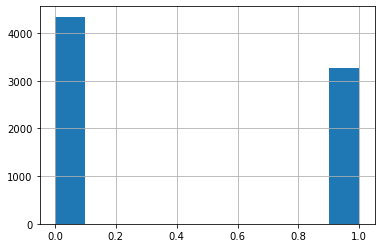

In [4]:
train_df['target'].hist()

In [5]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
def visualize(label):
  words = ''
  for msg in train_df[train_df['target'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

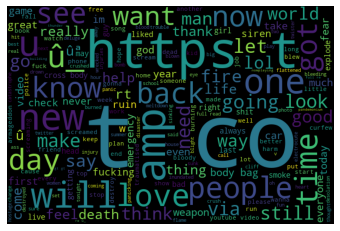

In [9]:
#non-disaster tweets before preprocesing
visualize(0)

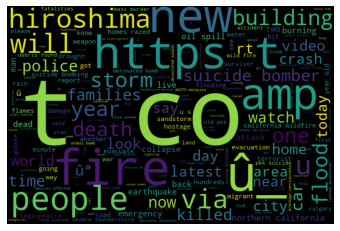

In [10]:
#disaster tweets before preprocesing
visualize(1)

In [11]:
train_df[train_df["target"] == 0]["text"].values[0]

"What's up man?"

In [12]:
train_df[train_df["target"] == 1]["text"].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [13]:
sub_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


# 2. Preprocessing 
most of preprocessing technic are by Rohit Garud https://www.kaggle.com/code/rohitgarud/all-almost-data-preprocessing-techniques-for-nlp#Final-Stopward-Removal  

In [14]:
#converting emojis
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text
train_df["text"] = train_df["text"].apply(convert_emojis)
test_df["text"] = test_df["text"].apply(convert_emojis)

In [15]:
#joining keywords with text      
train_df["keyword"] = train_df["keyword"].fillna("")
train_df["text"] = train_df["keyword"] + " " + train_df["text"]
test_df["keyword"] = test_df["keyword"].fillna("")
test_df["text"] = test_df["keyword"] + " " + test_df["text"]
train_df=train_df.drop(['keyword','location'],axis=1)
test_df=test_df.drop(['keyword','location'],axis=1)
train_df

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake ...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are...,1
3,6,"13,000 people receive #wildfires evacuation o...",1
4,7,Just got sent this photo from Ruby #Alaska as...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse in...,1
7609,10870,@aria_ahrary @TheTawniest The out of control ...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...,1
7611,10872,Police investigating after an e-bike collided...,1


In [16]:
#removing html code
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text
train_df["text"] = train_df["text"].apply(remove_html)
test_df["text"] = test_df["text"].apply(remove_html)
train_df

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [17]:
#converting capital letters
train_df["text"] = train_df["text"].str.lower()
test_df["text"] = test_df["text"].str.lower()
train_df

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @thetawniest the out of control w...,1
7610,10871,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1
7611,10872,police investigating after an e-bike collided ...,1


In [18]:
#removing urls
def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text
train_df["text"] = train_df["text"].apply(remove_urls)
test_df["text"] = test_df["text"].apply(remove_urls)
train_df

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @thetawniest the out of control w...,1
7610,10871,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,10872,police investigating after an e-bike collided ...,1


In [19]:
#removing mentions
def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text
train_df["text"] = train_df["text"].apply(remove_mentions)
test_df["text"] = test_df["text"].apply(remove_mentions)
train_df

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ...,1
7610,10871,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,10872,police investigating after an e-bike collided ...,1


In [20]:
#removing unicode chars
def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train_df["text"] = train_df["text"].apply(remove_unicode_chars)
test_df["text"] = test_df["text"].apply(remove_unicode_chars)
train_df

,id,text,target
0,1,our deeds are the reason of this #earthquake m...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,just got sent this photo from ruby #alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ...,1
7610,10871,m1.94 [01:04 utc]?5km s of volcano hawaii.,1
7611,10872,police investigating after an e-bike collided ...,1


In [21]:
#removing punctuations
string.punctuation
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
train_df["text"] = train_df["text"].apply(remove_punctuations)
test_df["text"] = test_df["text"].apply(remove_punctuations)
train_df

,id,text,target
0,1,our deeds are the reason of this earthquake m...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are ...,1
3,6,13 000 people receive wildfires evacuation or...,1
4,7,just got sent this photo from ruby alaska as ...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ...,1
7610,10871,m1 94 01 04 utc 5km s of volcano hawaii,1
7611,10872,police investigating after an e bike collided ...,1


In [22]:
#removing extra spaces
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train_df["text"] = train_df["text"].apply(remove_extra_spaces)
test_df["text"] = test_df["text"].apply(remove_extra_spaces)
train_df

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13 000 people receive wildfires evacuation ord...,1
4,7,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ev...,1
7610,10871,m1 94 01 04 utc 5km s of volcano hawaii,1
7611,10872,police investigating after an e bike collided ...,1


In [23]:
#correcting spelling with symspell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word, 
            Verbosity.CLOSEST, 
            max_edit_distance=2,
            include_unknown=True
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text
train_df["text"] = train_df["text"].apply(correct_spelling_symspell)
test_df["text"] = test_df["text"].apply(correct_spelling_symspell)
train_df

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la range sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,of 000 people receive wildfires evacuation ord...,1
4,7,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ev...,1
7610,10871,my of of of etc pm a of volcano hawaii,1
7611,10872,police investigating after an a bike collided ...,1


In [24]:
#Correcting Componded Words
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
def correct_spelling_symspell_compound(text):
    words = [
        sym_spell.lookup_compound(
            word, 
            max_edit_distance=2
            )[0].term 
        for word in text.split()] 
    text = " ".join(words)
    return text
train_df["text"] = train_df["text"].apply(correct_spelling_symspell_compound)
test_df["text"] = test_df["text"].apply(correct_spelling_symspell_compound)
train_df

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la range sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,of of a people receive wildfires evacuation or...,1
4,7,just got sent this photo from ruby alaska as s...,1
...,...,...,...
7608,10869,two giant cranes holding a bridge collapse int...,1
7609,10870,the out of control wild fires in california ev...,1
7610,10871,my of of of etc pm a of volcano hawaii,1
7611,10872,police investigating after an a bike collided ...,1


In [25]:
#removing stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
train_df["text"] = train_df["text"].apply(remove_stopwords)
test_df["text"] = test_df["text"].apply(remove_stopwords)
train_df

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la range sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...,1
7609,10870,control wild fires california even northern pa...,1
7610,10871,etc pm volcano hawaii,1
7611,10872,police investigating bike collided car little ...,1


In [26]:
# lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train_df["text"] = train_df["text"].apply(lemmatize_text)
test_df["text"] = test_df["text"].apply(lemmatize_text)
train_df

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la range sask canada,1
2,5,resident asked shelter place notified officer ...,1
3,6,people receive wildfire evacuation order calif...,1
4,7,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,1
7609,10870,control wild fire california even northern par...,1
7610,10871,etc pm volcano hawaii,1
7611,10872,police investigating bike collided car little ...,1


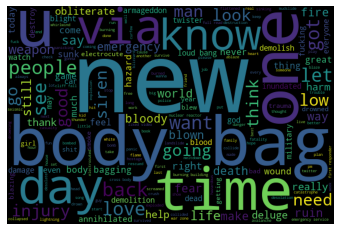

In [27]:
#non-disaster tweets after preprocesing
visualize(0)

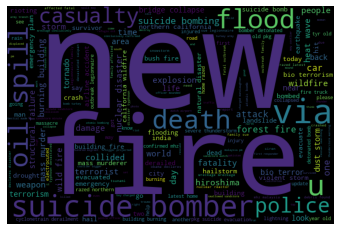

In [28]:
#disaster tweets after preprocesing
visualize(1)

# 3. Converting to vectors and training models

In [29]:
tfidf = TfidfVectorizer(max_features=105325,binary=True, analyzer='word',
            ngram_range=(1, 3), use_idf=True,smooth_idf=1,sublinear_tf=1,)
#max_features=10306
X = tfidf.fit_transform(train_df['text']).toarray()
y=train_df['target']
#norm{‘l1’
tfidfX_train, tfidfX_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)
print (tfidfX_train.shape)
print (tfidfX_test.shape)
tfidfX_test

(5100, 104974)
(2513, 104974)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# from imblearn.over_sampling import RandomOverSampler
# RandomOverSampler = RandomOverSampler(random_state = 42)
# tfidfX_train, y_train = RandomOverSampler.fit_resample(tfidfX_train, y_train)
# print (tfidfX_train.shape)

In [31]:
# from imblearn.over_sampling import SMOTE
# SMOTE = SMOTE(random_state = 42)
# tfidfX_train, y_train = SMOTE.fit_resample(tfidfX_train, y_train)
# print(tfidfX_train.shape)


In [32]:
clf1 = LogisticRegression()
clf1.fit(tfidfX_train, y_train)
predictions = clf1.predict_proba(tfidfX_test)
print("Train acc:", clf1.score(tfidfX_train, y_train))
print("Test acc:", clf1.score(tfidfX_test, y_test))

Train acc: 0.9235294117647059
Test acc: 0.7616394747313967


In [33]:
Pr_train = clf1.predict_proba(tfidfX_train)[:, 1]
Pr_test = clf1.predict_proba(tfidfX_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

Train AUC: 0.9901622865508218
Test AUC: 0.8635381707739154


In [34]:
y_predict = clf1.fit(tfidfX_train, y_train).predict(tfidfX_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.72      0.97      0.82      1446
           1       0.92      0.48      0.63      1067

    accuracy                           0.76      2513
   macro avg       0.82      0.72      0.73      2513
weighted avg       0.80      0.76      0.74      2513

[[1404   42]
 [ 557  510]]


In [35]:
clf2 = MultinomialNB()
clf2.fit(tfidfX_train, y_train)
predictions = clf2.predict_proba(tfidfX_test)
print("Train acc:", clf2.score(tfidfX_train, y_train))
print("Test acc:", clf2.score(tfidfX_test, y_test))

Train acc: 0.9694117647058823
Test acc: 0.7910863509749304


In [36]:
Pr_train = clf2.predict_proba(tfidfX_train)[:, 1]
Pr_test = clf2.predict_proba(tfidfX_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

Train AUC: 0.9853798906558644
Test AUC: 0.8570127203506166


In [37]:
y_predict = clf2.fit(tfidfX_train, y_train).predict(tfidfX_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1446
           1       0.89      0.58      0.70      1067

    accuracy                           0.79      2513
   macro avg       0.82      0.76      0.77      2513
weighted avg       0.81      0.79      0.78      2513

[[1368   78]
 [ 447  620]]


In [38]:
cvt = CountVectorizer(analyzer='word', binary=True,
            ngram_range=(1, 3) )
X = cvt.fit_transform(train_df['text'])
#.toarray()
y=train_df['target']

cvtX_train, cvtX_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)
print (cvtX_train.shape)
print (cvtX_test.shape)
cvtX_train

(5100, 104974)
(2513, 104974)


<5100x104974 sparse matrix of type '<class 'numpy.int64'>'
	with 125472 stored elements in Compressed Sparse Row format>

In [39]:
from imblearn.over_sampling import RandomOverSampler
RandomOverSampler = RandomOverSampler(
                                      random_state = 42)
cvtX_train, y_train = RandomOverSampler.fit_resample(cvtX_train, y_train)
print (cvtX_train.shape)

(5792, 104974)


In [40]:
# from imblearn.over_sampling import SMOTE
# SMOTE = SMOTE(random_state = 42)
# cvtX_train, y_train = SMOTE.fit_resample(cvtX_train, y_train)
# print(cvtX_train.shape)

In [41]:
clf3 = LogisticRegression()
clf3.fit(cvtX_train, y_train)
predictions = clf3.predict_proba(cvtX_test)######
print("Train acc:", clf3.score(cvtX_train, y_train))
print("Test acc:", clf3.score(cvtX_test, y_test))

Train acc: 0.9854972375690608
Test acc: 0.8002387584560287


In [42]:
Pr_train = clf3.predict_proba(cvtX_train)[:, 1]
Pr_test = clf3.predict_proba(cvtX_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

Train AUC: 0.9993613190035407
Test AUC: 0.8648052799890076


In [43]:
y_predict = clf3.fit(cvtX_train, y_train).predict(cvtX_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1446
           1       0.81      0.69      0.75      1067

    accuracy                           0.80      2513
   macro avg       0.80      0.79      0.79      2513
weighted avg       0.80      0.80      0.80      2513

[[1277  169]
 [ 333  734]]


In [44]:
clf4 = MultinomialNB()
clf4.fit(cvtX_train, y_train)
predictions = clf4.predict_proba(cvtX_test)
print("Train acc:", clf4.score(cvtX_train, y_train))
print("Test acc:", clf4.score(cvtX_test, y_test))

Train acc: 0.9772099447513812
Test acc: 0.8014325507361719


In [45]:
Pr_train = clf4.predict_proba(cvtX_train)[:, 1]
Pr_test = clf4.predict_proba(cvtX_test)[:, 1]
print("Train AUC:", roc_auc_score(y_train, Pr_train))
print("Test AUC:", roc_auc_score(y_test, Pr_test))

Train AUC: 0.9914040680038765
Test AUC: 0.8516043352634874


In [46]:
y_predict = clf4.fit(cvtX_train, y_train).predict(cvtX_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1446
           1       0.79      0.73      0.76      1067

    accuracy                           0.80      2513
   macro avg       0.80      0.79      0.79      2513
weighted avg       0.80      0.80      0.80      2513

[[1234  212]
 [ 287  780]]


In [47]:
test_df

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different city stay safe ever...
2,3,forest fire spot pond goose fleeing across str...
3,9,apocalypse lighting spokane wildfire
4,11,typhoon decor kill china taiwan
...,...,...
3258,10861,earthquake safety los angeles safety fastener
3259,10865,storm worse last hurricane city others hardest...
3260,10868,green line derailment chicago
3261,10874,meg issue hazardous weather outlook


In [48]:
test_df.text=cvt.transform(test_df.text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [49]:
test_predcit = clf3.predict(test_df.text)

test_predcit

array([1, 1, 1, ..., 1, 1, 1])

In [50]:
sub_df.target = test_predcit
sub_df.head(50)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [51]:
sub_df['target'].value_counts()

0    2135
1    1128
Name: target, dtype: int64

In [52]:
sub_df.to_csv('submission.csv', index=False)



Thank you, feedback is highly appreciated! :)

Please upvote if you found this helpful 👍
